# Read dataset

In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ml_functions import *

df = pd.read_csv('toy_dataset.csv', index_col=0)

df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

display(df.head())
print(df.shape)

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,r15,r16,InputA,InputI,OutputX,OutputN,id,growth,status,strain
0,0.00,0.10,-0.10,-0.20,1.20,1.00,1.00,1.00,1.00,-0.00,...,0.00,1.00,1.00,1.00,3.00,1.00,r1,3.00,infeasible,1
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r3,9.00,optimal,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r2,9.00,optimal,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r4,9.00,optimal,1
4,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,0.00,2.00,1.00,1.00,9.00,1.00,r5,9.00,infeasible,1


(4046, 25)


Intial dataset size.

In [3]:
df[['rxn_a','rxn_b','rxn_c']] = df['id'].str.split(',', expand=True)

#### Create `no_deletions` column keeping the number of deletions performed

In [4]:
def count_deletions(x):

    return len(x.split(','))

no_delitions = []
for row in range(len(df)):

    num = count_deletions(df['id'].iloc[row])
    no_delitions.append(num)

df['no_deletions'] = no_delitions
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
0,0.00,0.10,-0.10,-0.20,1.20,1.00,1.00,1.00,1.00,-0.00,...,3.00,1.00,r1,3.00,infeasible,1,r1,None,None,1
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r3,9.00,optimal,1,r3,None,None,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r2,9.00,optimal,1,r2,None,None,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r4,9.00,optimal,1,r4,None,None,1
4,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r5,9.00,infeasible,1,r5,None,None,1


### Store reactions names

In [5]:
# Store all reactions names
gem_rxn = df[df['no_deletions'] == 1]['id'].unique()

# Some statistical study

In [6]:
df['status'].value_counts()

infeasible    2802
optimal       1244
Name: status, dtype: int64

In [7]:
# Subset of df containing only infeasible rows
df_inf = df[df['status'] == 'infeasible']

Οι παρακάτω αντιδράσεις εάν κοπούν οδηγούν σε **infeasible** κατάσταση. Επομένως, ΔΕ θα πρέπει να περιλαμβάνονται στα deletions. Οι αντιδράσεις αυτές, δηλαδή, θα πρέπει να **προστατευτούν** από τα reaction deletions.

In [8]:
critical_rxn = df_inf[df_inf['no_deletions']==1]['id'].unique()
critical_rxn

array(['r1', 'r5', 'r6', 'r7', 'r8', 'r9', 'r11', 'r12', 'r13', 'outputK',
       'r16', 'OutputX'], dtype=object)

Οι αντιδράσεις που φαίνονται στο επόμενο κελί __ΔΕΝ__ οδήγησαν __ποτέ__ σε _infeasible_ status όταν κόπηκαν.

Μια λογική είναι να κοπούν οι παρακάτω αντιδράσεις. Εξαίρεση, οι αντιδράσεις που αφορούν input/output.

In [9]:
rxn_deletable = list(set(df_inf[df_inf['no_deletions']==1]['id'].unique()) ^ set(gem_rxn))
rxn_deletable

['InputA', 'r14', 'r2', 'r15', 'OutputN', 'r3', 'InputI', 'r10', 'r4']

In [10]:
index_del_rxn_a = df.loc[df['rxn_a'].isin(critical_rxn)].index
df.drop(index_del_rxn_a, inplace=True)

index_del_rxn_b = df.loc[df['rxn_b'].isin(critical_rxn)].index
df.drop(index_del_rxn_b, inplace=True)

index_del_rxn_c = df.loc[df['rxn_c'].isin(critical_rxn)].index
df.drop(index_del_rxn_c, inplace=True)

In [11]:
df.shape

(438, 29)

### Find and Delete Duplicated Rows 

In [12]:
index_a = df[df['rxn_a'] == df['rxn_b']].index
df.drop(index_a, axis=0, inplace=True)

index_b = df[df['rxn_a'] == df['rxn_c']].index
df.drop(index_b, axis=0, inplace=True)

index_c = df[df['rxn_b'] == df['rxn_c']].index
df.drop(index_c, axis=0, inplace=True)

df.shape

(258, 29)

In [13]:
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r3,9.00,optimal,1,r3,None,None,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r2,9.00,optimal,1,r2,None,None,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r4,9.00,optimal,1,r4,None,None,1
9,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r10,9.00,optimal,1,r10,None,None,1
14,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r14,9.00,optimal,1,r14,None,None,1


### Deletions matrix

"Binary" matrix:
    
    -cols: reactions
    
    -values: 1 (reaction is deleted) - 0 (otherwise)

In [14]:
# deletions = pd.DataFrame()

# for rxn in rxn_deletable:
#     deletions[rxn] = np.nan
    
# deletions['id'] = df['id']
# deletions.tail()

# for row in range(deletions.shape[0]):

#     deleted_rxn = deletions.iloc[row]['id']
    
#     for col in deletions.columns:
#         if(col in deleted_rxn): deletions[col].iloc[row] = 1

# deletions.fillna(0, inplace=True)

# new_names = []
# for col in deletions.columns:
#     new_names.append('del_'+col)
    
# deletions.columns = new_names
# deletions.drop('del_id', axis=1, inplace=True)

# df = pd.concat([df, deletions], axis=1)
# df.head()

In [15]:
# pd.set_option('display.max_columns', None)
# df.tail()

In [16]:
df.shape

(258, 29)

In [17]:
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r3,9.00,optimal,1,r3,None,None,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r2,9.00,optimal,1,r2,None,None,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r4,9.00,optimal,1,r4,None,None,1
9,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r10,9.00,optimal,1,r10,None,None,1
14,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,9.00,1.00,r14,9.00,optimal,1,r14,None,None,1


# Further Study dataset

In [18]:
pd.DataFrame(df[['growth']].describe()).T

,count,mean,std,min,25%,50%,75%,max
growth,258.00,4.94,3.37,-3.00,3.00,6.00,6.00,10.00


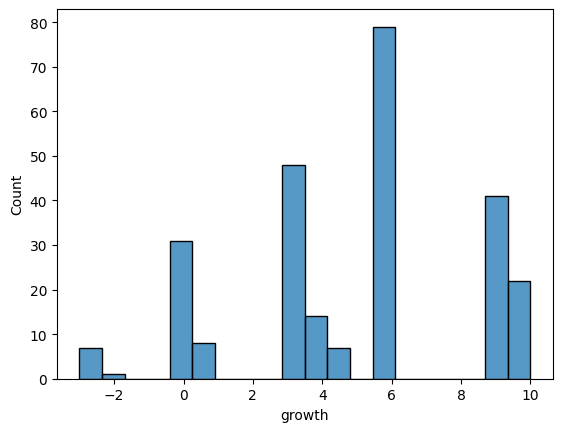

In [19]:
sns.histplot(data=df, x="growth", bins=20)
plt.show()

## Negative growth

In [20]:
df[df['growth'] < 0]

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
243,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"InputA,InputI",-3.00,infeasible,1,InputA,InputI,None,2
684,0.00,0.00,-1.00,-2.00,1.00,-1.00,-1.00,-1.00,-0.00,1.00,...,-3.00,1.00,"r3,InputA,InputI",-3.00,infeasible,1,r3,InputA,InputI,3
874,0.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"r2,InputA,InputI",-3.00,infeasible,1,r2,InputA,InputI,3
1045,0.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"r4,InputA,InputI",-3.00,infeasible,1,r4,InputA,InputI,3
1728,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,0.00,1.00,...,-3.00,1.00,"r10,InputA,InputI",-3.00,infeasible,1,r10,InputA,InputI,3
1958,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,-0.00,1.00,...,-3.00,1.00,"r14,InputA,InputI",-3.00,infeasible,1,r14,InputA,InputI,3
1979,0.00,0.10,-1.10,-2.20,1.20,-1.00,-1.00,-1.00,-0.00,1.00,...,-3.00,1.00,"r15,InputA,InputI",-3.00,infeasible,1,r15,InputA,InputI,3
2009,0.00,0.10,-0.43,-0.87,0.20,-0.67,-0.67,-1.00,-0.00,0.33,...,-2.00,0.00,"InputA,InputI,OutputN",-2.00,infeasible,1,InputA,InputI,OutputN,3
2544,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-1.00,0.00,1.00,...,-0.00,0.00,"r3,r2,OutputN",-0.00,optimal,2,r3,r2,OutputN,3
2562,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-1.00,0.00,1.00,...,-0.00,0.00,"r3,r4,OutputN",-0.00,optimal,2,r3,r4,OutputN,3


11 rows of __negative__ growth

Replace negative growth with 0

In [21]:
for row in range(len(df)):
    if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0

/tmp/ipykernel_7731/766195947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0


## Create _dummy variables_ for `status`

In [22]:
dummy_status = pd.get_dummies(df['status'])
df = pd.concat([df, dummy_status], axis=1)
df

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions,infeasible,optimal
1,1.00,0.00,1.00,2.00,1.00,3.00,3.00,3.00,1.00,0.00,...,r3,9.00,optimal,1,r3,None,None,1,0,1
2,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,r2,9.00,optimal,1,r2,None,None,1,0,1
3,1.00,1.00,0.00,0.00,3.00,3.00,3.00,3.00,1.00,0.00,...,r4,9.00,optimal,1,r4,None,None,1,0,1
9,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,r10,9.00,optimal,1,r10,None,None,1,0,1
14,1.00,0.10,0.90,1.80,1.20,3.00,3.00,3.00,1.00,0.00,...,r14,9.00,optimal,1,r14,None,None,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3986,1.00,1.00,-0.00,-0.00,2.00,2.00,2.00,2.00,0.00,0.00,...,"r14,InputI,OutputN",6.00,optimal,2,r14,InputI,OutputN,3,0,1
4002,0.00,0.10,-0.10,-0.20,0.20,0.00,0.00,0.00,0.00,-0.00,...,"r15,InputA,InputI",0.00,optimal,2,r15,InputA,InputI,3,0,1
4004,0.00,0.10,-0.10,-0.20,0.20,0.00,0.00,0.00,0.00,-0.00,...,"r15,InputA,OutputN",0.00,optimal,2,r15,InputA,OutputN,3,0,1
4007,1.00,1.00,-0.00,0.00,2.00,2.00,2.00,2.00,0.00,0.00,...,"r15,InputI,OutputN",6.00,optimal,2,r15,InputI,OutputN,3,0,1


### Check Linear Correlations

##### Point Biserial Correlation

In [23]:
pearsons = df.drop(columns=critical_rxn).corr(numeric_only=True)['optimal'].sort_values(ascending=False)
spearman = df.drop(columns=critical_rxn).corr(numeric_only=True, method='spearman')['optimal'].sort_values(ascending=False)

corr_matrix = pd.DataFrame({'pearsons':pearsons, 'spearman':spearman})
corr_matrix.sort_values(by='pearsons')

,pearsons,spearman
infeasible,-1.00,-1.00
no_deletions,-0.25,-0.24
InputI,-0.22,-0.22
r14,-0.21,-0.30
r15,-0.21,-0.16
OutputN,-0.13,-0.11
r2,-0.07,-0.13
r4,-0.07,-0.10
r10,0.01,0.13
growth,0.05,0.05


In [24]:
corr_matrix[abs(corr_matrix['pearsons']) < 0.1]

,pearsons,spearman
growth,0.05,0.05
r10,0.01,0.13
r2,-0.07,-0.13
r4,-0.07,-0.10


# AI / ML Ideas

## Create _training_ and _test_ sets and _data normalization_

Create a `df` keeping only _non critical_ reactions.

In [25]:
df.drop(columns=critical_rxn, inplace=True)

In [26]:
df.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN',
       'id', 'growth', 'status', 'strain', 'rxn_a', 'rxn_b', 'rxn_c',
       'no_deletions', 'infeasible', 'optimal'],
      dtype='object')

In [27]:
cols_to_drop = ['id', 'rxn_a', 'rxn_b', 'rxn_c', 'status']
df.drop(columns=cols_to_drop, inplace=True)

df.head()

,r3,r2,r4,r10,r14,r15,InputA,InputI,OutputN,growth,strain,no_deletions,infeasible,optimal
1,0.00,1.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
2,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
3,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
9,0.10,0.90,1.80,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1
14,0.10,0.90,1.80,0.00,0.00,0.00,1.00,1.00,1.00,9.00,1,1,0,1


In [28]:
df.shape

(258, 14)

### Basic ML libraries

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Define **target** variable

We need to better define the target that we want to predict!

(The most simple and obvious answer is to predit **optimal** column)

Θα *δοκιμάσω* να χρησιμοποιήσω ως στόχο την πρόβλεψη του αν πρόκειται για infeasible

In [31]:
# df['target'] = (1-df['good_growth']) * df['infeasible']
df['target'] = df['infeasible']
df['target'].value_counts()

0    178
1     80
Name: target, dtype: int64

In [32]:
df.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN',
       'growth', 'strain', 'no_deletions', 'infeasible', 'optimal', 'target'],
      dtype='object')

In [33]:
X = df.drop(['optimal', 'infeasible', 'growth', 'strain', 'no_deletions', 'target'], axis=1)
y = df['target']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y, random_state=42)

(258, 9)
(258,)


In [34]:
X_train.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN'], dtype='object')

Use of stratify sampling to get the same optimal/infeasible rates on train and test sets as to the original dataset.

In [35]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression().fit(X_train_scaled, y_train)

validation_classification(lr_model, X_test_scaled, y_test)

ROC-AUC = 0.6145833333333334
ACCURACY = 0.7307692307692307
F1 = 0.4166666666666667


### SVM Classifier

In [37]:
svc_model, svc_scores = train_svm(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [38]:
validation_classification(svc_model, X_test_scaled, y_test)

ROC-AUC = 0.5
ACCURACY = 0.6923076923076923
F1 = 0.0


### XGBoost Classifier

In [39]:
xgb_model, xgb_scores = xgb_classifier(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 2/20] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 1/3; 2/20] END C=0.1, gamma=0.01, kernel=rbf;, score=0.759 total time=   0.0s
[CV 3/3; 5/20] START C=0.05, gamma=0.1, kernel=rbf..............................
[CV 3/3; 5/20] END C=0.05, gamma=0.1, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3; 7/20] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 1/3; 7/20] END C=0.01, gamma=0.1, kernel=rbf;, score=0.759 total time=   0.0s
[CV 1/3; 8/20] START C=0.05, gamma=5, kernel=linear.............................
[CV 1/3; 8/20] END C=0.05, gamma=5, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3; 9/20] START C=0.5, gamma=1, kernel=rbf.................................
[CV 1/3; 9/20] END ..C=0.5, gamma=1, kernel=rbf;, score=0.905 total time=   0.0s
[CV 3/3; 10/20] START C=0.01, gamma=10, kernel=linear..........

[CV 1/3; 3/20] START C=0.5, gamma=10, kernel=linear.............................
[CV 1/3; 3/20] END C=0.5, gamma=10, kernel=linear;, score=0.606 total time=   0.0s
[CV 1/3; 13/20] START C=10, gamma=1, kernel=linear..............................
[CV 1/3; 13/20] END C=10, gamma=1, kernel=linear;, score=0.557 total time=   0.0s
[CV 1/3; 15/20] START C=0.01, gamma=0.01, kernel=rbf............................
[CV 1/3; 15/20] END C=0.01, gamma=0.01, kernel=rbf;, score=0.679 total time=   0.0s
[CV 2/3; 15/20] START C=0.01, gamma=0.01, kernel=rbf............................
[CV 2/3; 15/20] END C=0.01, gamma=0.01, kernel=rbf;, score=0.686 total time=   0.0s
[CV 3/3; 19/20] START C=100, gamma=0.1, kernel=linear...........................
[CV 3/3; 19/20] END C=100, gamma=0.1, kernel=linear;, score=0.379 total time=   0.0s
[CV 3/3; 2/20] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 3/3; 2/20] END C=0.1, gamma=0.01, kernel=rbf;, score=0.603 total time=   0.0s
[CV 2/3; 5/20]

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [40]:
validation_classification(xgb_model, X_test_scaled, y_test)

ROC-AUC = 0.670138888888889
ACCURACY = 0.7115384615384616
F1 = 0.5454545454545455


# Feature Importance to detect reactions for knock-out

In [41]:
import shap

explainer = shap.TreeExplainer(xgb_model, X_test_scaled, feature_names=X_test.columns)
shap_values = explainer(X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


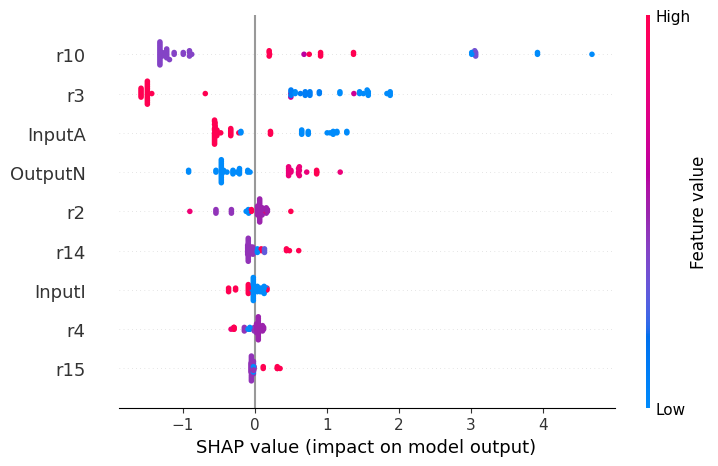

In [42]:
shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])

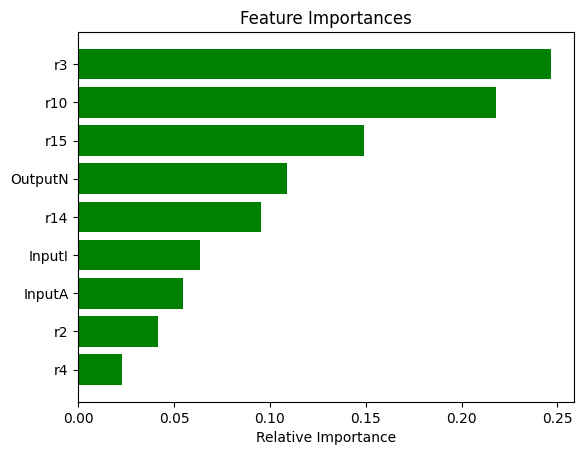

In [44]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Artificial Neural Networks

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2022-11-14 20:07:56.941657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 20:07:57.349961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 20:07:57.350014: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-14 20:07:57.410494: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 20:07:58.369428: W tensorflow/stream_executor/platform/de

In [46]:
n_inputs = len(X_train.columns)

In [47]:
model = Sequential()
model.add(Dense(25, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=5)

2022-11-14 20:08:08.407517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-14 20:08:08.407752: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 20:08:08.407775: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (comex-dell): /proc/driver/nvidia/version does not exist
2022-11-14 20:08:08.408511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
42/42 [==============================] - 1s 972us/step - loss: 0.7662 - accuracy: 0.5146 - precision: 0.3421 - recall: 0.6094
Epoch 2/10
42/42 [==============================] - 0s 1ms/step - loss: 0.6326 - accuracy: 0.6650 - precision: 0.4658 - recall: 0.5312
Epoch 3/10
42/42 [==============================] - 0s 1ms/step - loss: 0.5565 - accuracy: 0.6796 - precision: 0.4857 - recall: 0.5312
Epoch 4/10
42/42 [==============================] - 0s 1ms/step - loss: 0.5172 - accuracy: 0.7524 - precision: 0.6383 - recall: 0.4688
Epoch 5/10
42/42 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7816 - precision: 0.6863 - recall: 0.5469    
Epoch 6/10
42/42 [==============================] - 0s 1ms/step - loss: 0.4689 - accuracy: 0.7816 - precision: 0.6863 - recall: 0.5469    
Epoch 7/10
42/42 [==============================] - 0s 1ms/step - loss: 0.4527 - accuracy: 0.7864 - precision: 0.7000 - recall: 0.5469    
Epoch 8/10
42/42 [=======================

In [48]:
score = model.evaluate(X_test_scaled, y_test,verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7500 - precision: 0.6667 - recall: 0.3750


In [49]:
import shap


explainer = shap.DeepExplainer(model, X_train_scaled)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [50]:
shap_values = explainer.shap_values(X_test_scaled)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


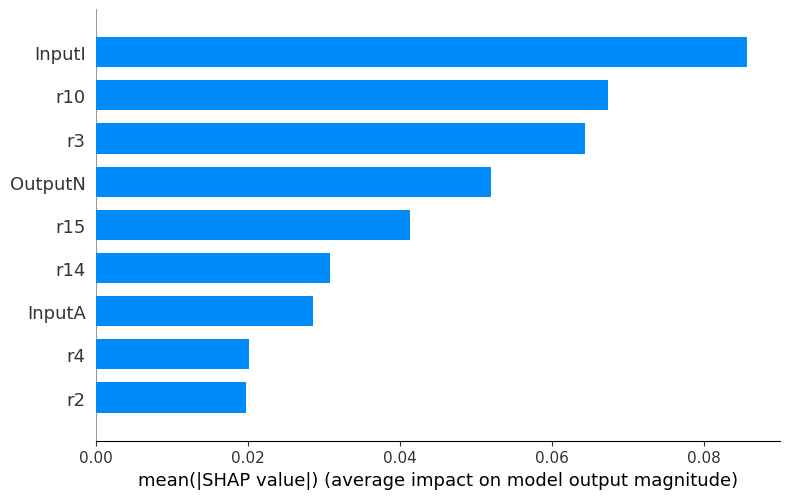

In [51]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns, max_display=X_test.shape[1])

# ELI5 

In [52]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from sklearn.svm import SVC

perm = PermutationImportance(xgb_model).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.1077 ± 0.0392,r10
0.0308 ± 0.0522,InputA
-0.0154 ± 0.0154,r15
-0.0192 ± 0.0344,r4
-0.0423 ± 0.0377,r2
-0.0500 ± 0.0713,OutputN
-0.0538 ± 0.0449,r3
-0.0615 ± 0.0449,r14
-0.0731 ± 0.0288,InputI


# Feature Selection

In [53]:
from sklearn.feature_selection import RFE

estimator = xgb_model

selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train_scaled, y_train)

selected_features = pd.DataFrame()
selected_features['selected'] = selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = selector.ranking_
selected_features[selected_features['selected'] == True]

,selected,features_names,rank
0,True,r3,1
4,True,r14,1
7,True,InputI,1
8,True,OutputN,1


In [54]:
estimator = xgb.XGBClassifier()

selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train_scaled, y_train)

selected_features = pd.DataFrame()
selected_features['selected'] = selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = selector.ranking_
selected_features[selected_features['selected'] == True]

,selected,features_names,rank
0,True,r3,1
3,True,r10,1
6,True,InputA,1
7,True,InputI,1


In [55]:
selected_features[selected_features['selected'] == False].sort_values(by='rank')

,selected,features_names,rank
8,False,OutputN,2
1,False,r2,3
4,False,r14,4
5,False,r15,5
2,False,r4,6


# Validate Deletions

In [56]:
from cobra.io import load_model
from cobra.io.json import load_json_model

from main import *

# cobra_model = load_model("textbook")

# Load toy models created by Stefanos
cobra_model_1 = load_json_model('toy_1.json')
cobra_model_2 = load_json_model('toy_2.json')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [57]:
ann = ['r4', 'r15', 'r14']

with cobra_model_1:
    for rxn in ann:
        cobra_model_1.reactions.get_by_id(rxn).knock_out()
    solution =  cobra_model_1.optimize()    
    print(solution.objective_value)
    print(solution.status)

with cobra_model_2:
    for rxn in ann:
        cobra_model_2.reactions.get_by_id(rxn).knock_out()
    solution =  cobra_model_2.optimize()    
    print(solution.objective_value)
    print(solution.status)

9.0
optimal
6.000000000000001
optimal
